# Kernel density estimation

Exploring different approaches in bonded spaces

Let's start with a sample from a uniform distribution, and try to recover the pdf.

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#dist = stats.uniform(0, 1)
dist = stats.triang(1)

In [3]:
n_data = 100
data = dist.rvs(n_data)

First, here's a big function to handle everything.

In [4]:
def plot_kde(ax, func=None, dist=None, data=None):
    xpts = np.linspace(-0.25, 1.25, 500)
    if dist is not None:
        ax.plot(xpts,
                dist.pdf(xpts),
                color='r',
                label='actual')
    if func is None:
        ax.hist(data,
                bins=np.linspace(0, 1, 11),
                density=True);
    else:
        kde = func(data)
        ax.plot(xpts,
                kde(xpts),
               label='kde')
    ax.set_ylim(ymin=0)
    ax.set_xlim(-0.25, 1.25)
    if data is not None:
        for datum in data:
            ax.axvline(datum, color='k', lw=1, alpha=0.2)
    ax.legend()

Here's a histogram.

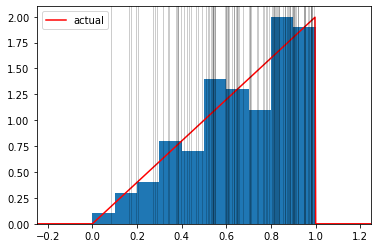

In [5]:
fig, ax = plt.subplots()

plot_kde(ax, None, dist, data)

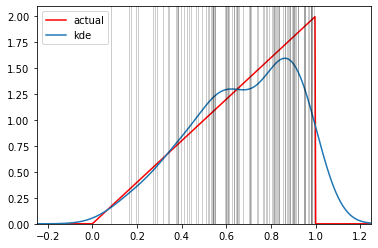

In [6]:
fig, ax = plt.subplots()
plot_kde(ax, stats.gaussian_kde, dist, data)

There's a clear dip near the edges as the gaussians leak out the side.


Now we'll create a bounded kde by transforming it.

In [7]:
from scipy.special import logit
def transforming_bounded_kde(data):
    """return a gaussian kde function bounded (for now) between 0 and 1, in 1 dimension
    Note that it doesn't handle x=0 or x=1. It should get some limit."""
    kde = stats.gaussian_kde(logit(data))
    return lambda x: kde(logit(x))/(x*(1-x))

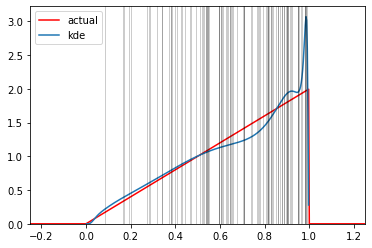

In [8]:
fig, ax = plt.subplots()
plot_kde(ax, transforming_bounded_kde, dist, data)

That's weird in different ways.

How about a reflexive approach?

In [9]:
# nb this assume the original kde decays to zero
# by -1 and 2, so doesn't reflect of both ends
def reflecting_bounded_kde(data):
    kde = stats.gaussian_kde(data)
    def rbkde(x):
        result = np.where
    return lambda x: np.where(x < 0,
                              0,
                              np.where(x > 1,
                                       0,
                                       kde(x)+
                                       kde(-x)+
                                       kde(2-x)))

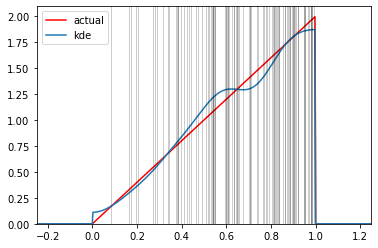

In [10]:
fig, ax = plt.subplots()
plot_kde(ax, reflecting_bounded_kde, dist, data)

Combining these to a single chart.

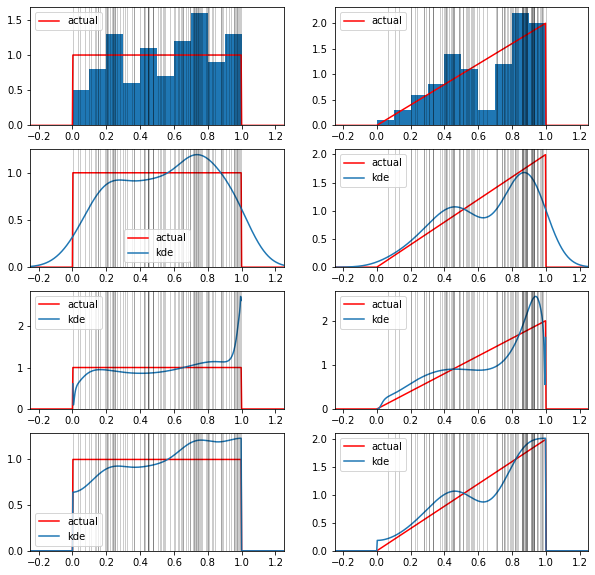

In [11]:
fig, axs = plt.subplots(4, 2, figsize=(10, 10))

for i, dist in enumerate([stats.uniform(0, 1),
                          stats.triang(1)]):
    data = dist.rvs(n_data)
    for ax, func in zip(axs[:, i],
                        [None,
                         stats.gaussian_kde,
                         transforming_bounded_kde,
                         reflecting_bounded_kde]):
        plot_kde(ax, func, dist, data)

Let's try it a bit differently, putting them all in a single chart.

In [12]:
def plot_kdes(ax, funcs, dist=None, data=None):
    xpts = np.linspace(-0.25, 1.25, 500)
    if dist is not None:
        ax.plot(xpts,
                dist.pdf(xpts),
                color='r',
                label='actual')
    for func in funcs:
        kde = func(data)
        ax.plot(xpts,
                kde(xpts),
               label=func.__name__)
    ax.set_ylim(ymin=0)
    ax.set_xlim(-0.25, 1.25)
    if data is not None:
        for datum in data:
            ax.axvline(datum, color='k', lw=1, alpha=0.1)
    ax.legend()

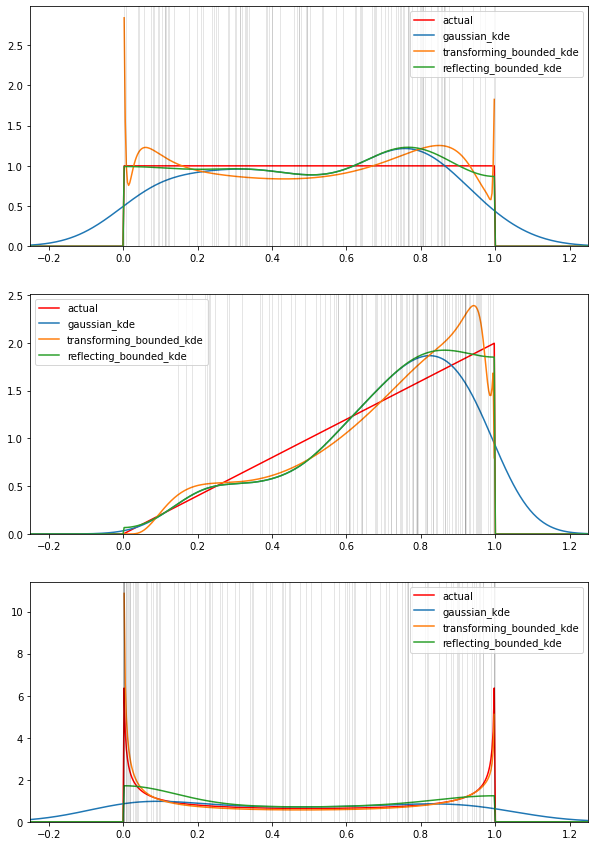

In [13]:
fig, axs = plt.subplots(3, figsize=(10, 15))

for ax, dist in zip(axs,
                    [stats.uniform(0, 1),
                     stats.triang(1),
                     stats.beta(0.5, 0.5)]):
    data = dist.rvs(n_data)
    plot_kdes(ax,
              [stats.gaussian_kde,
               transforming_bounded_kde,
               reflecting_bounded_kde],
              dist,
              data)

And finally we have a case where the transforming approach succeeds.

One possible problem with reflection is that it biases the results away from the bonds. Let's investigate with evenly spaced data.

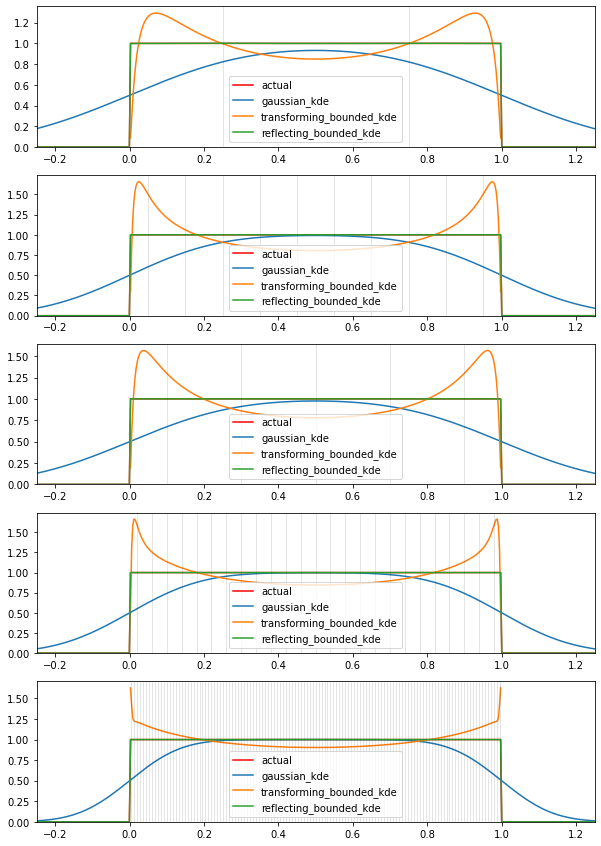

In [14]:
fig, axs = plt.subplots(5, figsize=(10, 15))

for ax, step in zip(axs, (0.5, 0.1, 0.2, 0.04, 0.008)):
    data = np.arange(step/2, 1, step)
    plot_kdes(ax,
              [stats.gaussian_kde,
               transforming_bounded_kde,
               reflecting_bounded_kde],
              stats.uniform(0, 1),
              data)

It looks as if that's not a big issue, though; the difference from a uniform distribution isn't even visible.

Next up: evaluate the differences between distributions, maybe with  the Kullback-Leibler divergence or something similar, and as part of that consider what measure of difference is the most appropriate. 